## <b>BILLION BANK</b>

 # 0.0 IMPORTAÇÕES E FUNÇÕES DE AJUDA


In [1]:
import pickle
import warnings
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt
import datetime               as dt
import xgboost                as xgb

from scipy                    import stats        as ss

from boruta                   import BorutaPy
from random                   import choices
from scikitplot.metrics       import plot_confusion_matrix, plot_calibration_curve, plot_cumulative_gain, plot_roc
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection  import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble         import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model     import LogisticRegression, RidgeClassifier
from lightgbm                 import LGBMClassifier
from scikitplot.metrics       import plot_confusion_matrix, plot_roc_curve, plot_cumulative_gain
from sklearn.metrics          import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score
from imblearn.combine         import SMOTETomek
from category_encoders        import MEstimateEncoder, TargetEncoder
from xgboost                  import XGBClass

warnings.filterwarnings("ignore")

In [2]:
def df_scores(model_name, y_test, y_pred, y_proba, normalize=False):  

 
    fig, ax = plt.subplots(1, 3, figsize=(25,5))
    plot_confusion_matrix(y_true = y_test, y_pred= y_pred, figsize=(10,10), ax=ax[0])
    plot_cumulative_gain(y_test, y_proba, figsize=(10,10), ax=ax[1])
    plot_roc(y_test, y_proba, ax=ax[2])
    results = {'accuracy_score': accuracy_score(y_test, y_pred),
               'precision_score': precision_score(y_test, y_pred),
               'recall_score': recall_score(y_test, y_pred),
               'f1_score': f1_score(y_test, y_pred),
               'roc_auc': roc_auc_score(y_test, y_pred),
               'kappa_score': cohen_kappa_score(y_test, y_pred)}
    results = pd.DataFrame(results, index=[model_name])

        

    return results if normalize == False else np.round(results * 100, 3)


def cross_validation(model, x, y, k, verb):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True)
    i=1
    f1_list = []
    acc_list = []

    for train_ix, val_ix in kfold.split(x, y):
        if verb:
            print(f'{i} -> {k} Cross Validation Folds')

        # Get Dataset Folders
        x_train_fold = x.iloc[train_ix]
        y_train_fold = y.iloc[train_ix]
        x_val_fold = x.iloc[val_ix]
        y_val_fold = y.iloc[val_ix]

        # Model Train 
        model = model.fit(x_train_fold, y_train_fold)
        yhat_label = model.predict(x_val_fold)
        #yhat_proba = model.predict_proba(x_val_fold)

        acc_list.append(accuracy_score(y_val_fold, yhat_label))
        f1_list.append(f1_score(y_val_fold, yhat_label))

        i+=1

    df = pd.DataFrame(columns=["Model Name", "Accuracy", "f1_score"], index=[-1])
    df["Model Name"] = df["Model Name"].fillna(type(model).__name__)
    df["Accuracy"]  = str(round(np.mean(acc_list), 4)) + " + / - " + str(round(np.std(acc_list), 4)) 
    df["f1_score"] = str(round(np.mean(f1_list), 4)) + " + / - " + str(round(np.std(f1_list), 4))
    
    return df.reset_index(drop=True)

def sanitiza (df2):    
    # Potencial de Investidor por Ano    
    df2['pot_inv'] = df2['valor_em_investimentos'] / (df2['idade'] - 17) 

    df2['pot_endiv'] = df2['divida_atual'] / (df2['idade'] - 17)

    df2['pot_capital'] = df2['pot_endiv'] - df2['pot_inv']

    df2['end_rend'] = df2['divida_atual'] / df2['renda_anual']

    df2['comprometimento_salario'] =  df2['divida_atual'] / df2['renda_anual']

    df3 = df2.copy()

    df3 = df3.drop(['id_cliente'], axis = 1)

    df3 = df3.drop(['pessoa_polit_exp'], axis = 1)

    return df3


def submission (response):
    a = pd.read_csv('data/sample_submission.csv')
    a['limite_adicional'] = response
    a['limite_adicional'] = a['limite_adicional'].apply(lambda x: 'Negar' if x == 0 else 'Conceder')

    csv = a.to_csv('result.csv', index = False)   



def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 30
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
mms = MinMaxScaler()
rs = RobustScaler()
le = LabelEncoder()

In [4]:
df_raw = pd.read_csv('data/train.csv')
X_valid = pd.read_csv('data/test.csv')


# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Tamanho do DataSet

In [6]:
print(f'Números de linhas: {df1.shape[0]}')
print(f'Números de colunas: {df1.shape[1]}')

Números de linhas: 9500
Números de colunas: 17


## 1.2 Nomes das Colunas

In [7]:
df1.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

## 1.3 Tipos de Dados

In [8]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.5 Estatística Descritiva

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [11]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id_cliente,1.000000,1.250000e+04,1.249900e+04,6210.532947,6172.500000,3.603054e+03,0.014114,-1.199109
1,idade,18.000000,8.598000e+03,8.580000e+03,126.398421,38.000000,6.849999e+02,9.092579,87.613308
2,saldo_atual,0.088628,1.602041e+03,1.601952e+03,404.532032,337.169588,2.176853e+02,1.621743,3.104578
3,divida_atual,0.230000,4.998070e+03,4.997840e+03,1437.086420,1175.730000,1.156202e+03,1.187913,0.848447
4,renda_anual,10473.865350,2.327966e+07,2.326918e+07,195037.274234,45991.106000,1.454197e+06,11.874057,149.389202
5,valor_em_investimentos,0.000000,1.000000e+04,1.000000e+04,611.999323,134.201478,2.002338e+03,4.436327,17.868001
6,taxa_utilizacao_credito,20.992914,4.956452e+01,2.857161e+01,32.270823,32.262649,5.105784e+00,0.042483,-0.915879
7,num_emprestimos,0.000000,1.496000e+03,1.496000e+03,10.863684,3.000000,6.255212e+01,16.366227,310.979754
8,num_contas_bancarias,0.000000,1.779000e+03,1.779000e+03,17.552316,6.000000,1.209738e+02,10.877721,123.218353
9,num_cartoes_credito,1.000000,1.479000e+03,1.478000e+03,21.433158,6.000000,1.226709e+02,8.564262,76.794957


# 2.0 FEATURE ENGENEERING

In [12]:
df2 = df1.copy()

In [13]:
# Potencial de Investidor por Ano
df2['pot_inv'] = df2['valor_em_investimentos'] / (df2['idade'] - 17) 

# Potencial de Endividamento por Ano
df2['pot_endiv'] = df2['divida_atual'] / (df2['idade'] - 17)

# Potencial de Capital por Ano
df2['pot_capital'] = df2['pot_endiv'] - df2['pot_inv']

# Endividamento / Renda 
df2['end_rend'] = df2['divida_atual'] / df2['renda_anual']


df2['comprometimento_salario'] =  df2['divida_atual'] / df2['renda_anual']

In [14]:
df2

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional,pot_inv,pot_endiv,pot_capital,end_rend,comprometimento_salario
0,1767,21,278.172008,2577.05,24196.89636,104.306544,31.038763,6,5,7,21,14,9,15,Não,Não,Negar,26.076636,644.262500,618.185864,0.106503,0.106503
1,11920,40,268.874152,2465.39,19227.37796,69.858778,36.917093,5,8,5,40,23,10,18,Não,Não,Negar,3.037338,107.190870,104.153531,0.128223,0.128223
2,8910,36,446.643127,1055.29,42822.28223,134.201478,34.561714,0,3,6,26,13,3,15,Sim,Não,Negar,7.063236,55.541579,48.478343,0.024643,0.024643
3,4964,58,321.141267,703.05,51786.82600,297.350067,31.493561,0,3,7,12,7,2,1,Sim,Não,Negar,7.252441,17.147561,9.895120,0.013576,0.013576
4,10100,35,428.716114,891.29,44626.85346,134.201478,28.028887,2,8,7,24,10,8,20,Sim,Não,Negar,7.455638,49.516111,42.060473,0.019972,0.019972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9495,5155,29,157.500279,157.98,32624.67754,237.739275,32.407322,100,4,4,24,15,1,14,Sim,Não,Negar,19.811606,13.165000,-6.646606,0.004842,0.004842
9496,11977,1237,497.714090,805.43,49024.15700,118.883577,23.632195,0,4,7,10,11,2,3,Não,Não,Negar,0.097446,0.660189,0.562743,0.016429,0.016429
9497,9278,47,306.557684,2250.42,42200.88978,134.201478,34.623576,4,4,4,13,8,4,24,Não,Não,Negar,4.473383,75.014000,70.540617,0.053326,0.053326
9498,2525,42,209.870718,505.37,35391.32289,245.498881,28.758818,3,7,6,24,13,3,11,Sim,Não,Negar,9.819955,20.214800,10.394845,0.014279,0.014279


# 3.0 FILTRAGEM DE DADOS

In [15]:
df3 = df2.copy()

In [16]:
# dropando o ID
df3 = df3.drop(['id_cliente'], axis = 1)

df3 = df3.drop(['pessoa_polit_exp'], axis = 1)

# Removendo inconsistencias na idade.
df3 = df3[df3['idade'] <= 100]

# Removendo inconsistencias na num_emprestimos.
df3 = df3[df3['num_emprestimos'] <= 30]

# Removendo inconsistencias na num_contas_bancarias.
df3 = df3[df3['num_contas_bancarias'] <= 10]

# Removendo inconsistencias na num_cartoes_credito.
df3 = df3[df3['num_cartoes_credito'] <= 10]

# Removendo inconsistencias na num_pagtos_atrasados.
df3 = df3[df3['num_pgtos_atrasados'] <= 50]

# Removendo inconsistencias na num_consultas_credito.
df3 = df3[df3['num_consultas_credito'] <= 50]

# Removendo inconsistencias na taxa_juros.
df3 = df3[df3['taxa_juros'] <= 500]


#---------------------- Sanitizado ------------------

# Transformando a variável resposta em boolean 
df3['limite_adicional'] = df3['limite_adicional'].apply(lambda x: 0 if x == 'Negar' else 1)

In [17]:
df3

,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,limite_adicional,pot_inv,pot_endiv,pot_capital,end_rend,comprometimento_salario
0,21,278.172008,2577.05,24196.89636,104.306544,31.038763,6,5,7,21,14,9,15,Não,0,26.076636,644.262500,618.185864,0.106503,0.106503
1,40,268.874152,2465.39,19227.37796,69.858778,36.917093,5,8,5,40,23,10,18,Não,0,3.037338,107.190870,104.153531,0.128223,0.128223
2,36,446.643127,1055.29,42822.28223,134.201478,34.561714,0,3,6,26,13,3,15,Sim,0,7.063236,55.541579,48.478343,0.024643,0.024643
3,58,321.141267,703.05,51786.82600,297.350067,31.493561,0,3,7,12,7,2,1,Sim,0,7.252441,17.147561,9.895120,0.013576,0.013576
4,35,428.716114,891.29,44626.85346,134.201478,28.028887,2,8,7,24,10,8,20,Sim,0,7.455638,49.516111,42.060473,0.019972,0.019972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,47,334.607755,2507.45,27073.47258,37.650211,27.923832,6,6,6,21,18,6,17,Não,0,1.255007,83.581667,82.326660,0.092616,0.092616
9493,25,969.492340,1404.39,126281.08896,111.854530,36.699685,2,2,3,2,8,3,2,Não,0,13.981816,175.548750,161.566934,0.011121,0.011121
9494,50,245.825419,2698.44,62096.36475,72.102957,33.525348,8,8,7,48,20,8,24,Não,0,2.184938,81.770909,79.585971,0.043456,0.043456
9497,47,306.557684,2250.42,42200.88978,134.201478,34.623576,4,4,4,13,8,4,24,Não,0,4.473383,75.014000,70.540617,0.053326,0.053326


# 4.0 PREPARAÇÃO DOS DADOS

In [18]:
df4 = df3.copy()

In [19]:
y = df4['limite_adicional']
X = df4.drop(['limite_adicional'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 5.0 TRANSFORMAÇÕES

In [20]:
sanitiza(X_valid)

,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pot_inv,pot_endiv,pot_capital,end_rend,comprometimento_salario
0,32,470.690627,605.03,42688.60400,104.291825,24.464031,1,2,4,3,4,2,6,Não,6.952788,40.335333,33.382545,0.014173,0.014173
1,25,288.605522,943.86,43545.94475,276.725394,39.797764,0,7,5,5,14,4,5,Não,34.590674,117.982500,83.391826,0.021675,0.021675
2,35,740.196090,548.20,82208.44752,98.674410,39.962685,0,4,1288,12,10,2,8,Não,5.481912,30.455556,24.973644,0.006668,0.006668
3,7586,298.192158,1704.18,41749.69050,162.441009,24.448063,3,8,7,30,11,5,15,Não,0.021461,0.225153,0.203691,0.040819,0.040819
4,49,341.554423,421.43,42381.95080,154.352781,29.519353,2,0,5,4,0,2,12,Não,4.823524,13.169688,8.346163,0.009944,0.009944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,48,417.139276,636.96,45532.40174,94.723661,25.382445,2,7,3,6,8,4,19,Sim,3.055602,20.547097,17.491495,0.013989,0.013989
2996,43,720.344280,717.79,95347.46144,160.090877,27.777284,2,6,7,30,20,5,11,Sim,6.157341,27.607308,21.449966,0.007528,0.007528
2997,44,874.910490,361.68,97517.21808,98.884010,43.307916,0,2,7,5,7,1,7,Não,3.662371,13.395556,9.733185,0.003709,0.003709
2998,24,349.184777,678.57,46943.70275,131.988993,35.123923,4,4,4,11,4,3,3,Não,18.855570,96.938571,78.083001,0.014455,0.014455


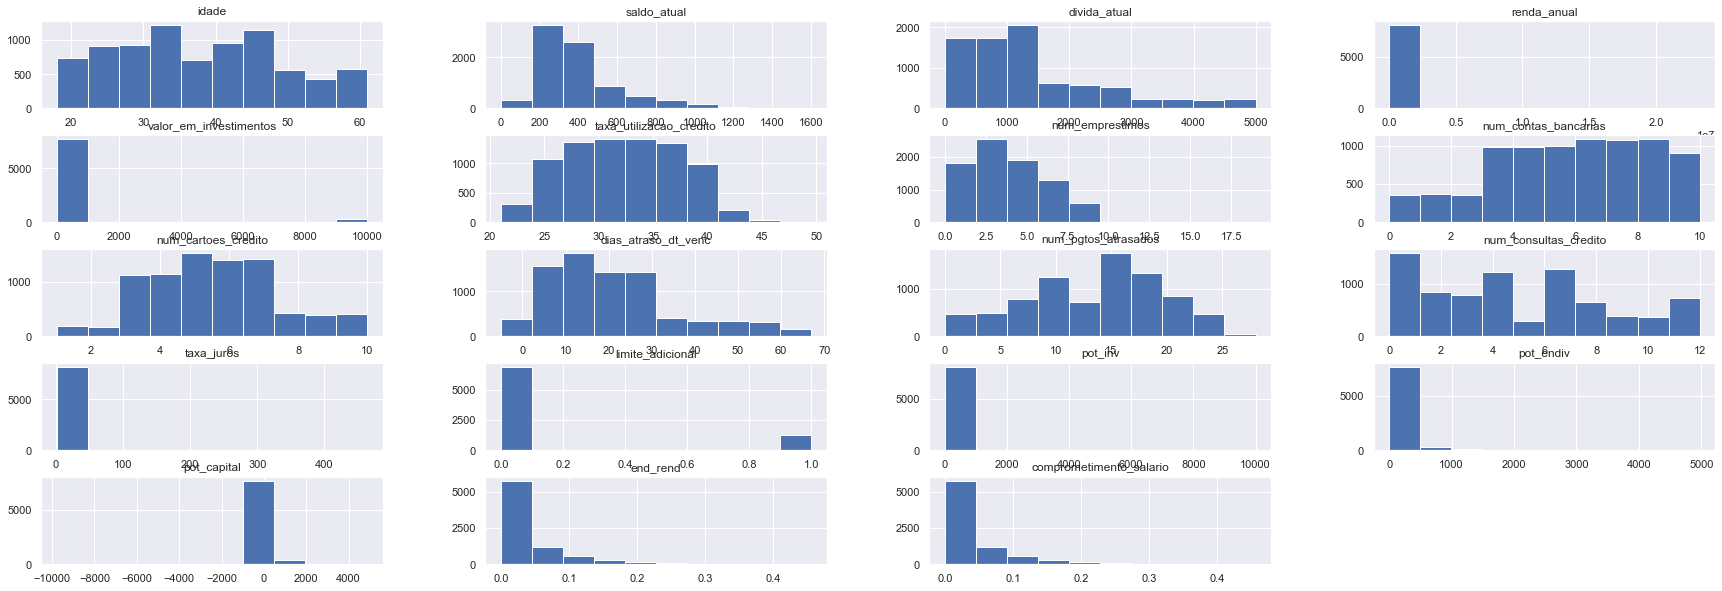

In [21]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(figsize = (30,10));

In [22]:
X_train['idade'] = mms.fit_transform(X_train[['idade']].values)
X_test['idade'] = mms.fit_transform(X_test[['idade']].values)
X_valid['idade'] = mms.fit_transform(X_valid[['idade']].values)

X_train['saldo_atual'] = np.log1p(X_train['saldo_atual'])
X_test['saldo_atual'] = np.log1p(X_test['saldo_atual'])
X_valid['saldo_atual'] = np.log1p(X_valid['saldo_atual'])

X_train['divida_atual'] = np.log1p(X_train['divida_atual'])
X_test['divida_atual'] = np.log1p(X_test['divida_atual'])
X_valid['divida_atual'] = np.log1p(X_valid['divida_atual'])

X_train['renda_anual'] = rs.fit_transform(X_train[['renda_anual']].values)
X_test['renda_anual'] = rs.fit_transform(X_test[['renda_anual']].values)
X_valid['renda_anual'] = rs.fit_transform(X_valid[['renda_anual']].values)

X_train['valor_em_investimentos'] = rs.fit_transform(X_train[['valor_em_investimentos']].values)
X_valid['valor_em_investimentos'] = rs.fit_transform(X_valid[['valor_em_investimentos']].values)
X_valid['valor_em_investimentos'] = mms.fit_transform(X_valid[['valor_em_investimentos']].values)

X_train['taxa_utilizacao_credito'] = mms.fit_transform(X_train[['taxa_utilizacao_credito']].values)
X_test['taxa_utilizacao_credito'] = mms.fit_transform(X_test[['taxa_utilizacao_credito']].values)
X_valid['taxa_utilizacao_credito'] = mms.fit_transform(X_valid[['taxa_utilizacao_credito']].values)

X_train['num_emprestimos'] = rs.fit_transform(X_train[['num_emprestimos']].values)
X_test['num_emprestimos'] = rs.fit_transform(X_test[['num_emprestimos']].values)
X_valid['num_emprestimos'] = rs.fit_transform(X_valid[['num_emprestimos']].values)

X_train['num_contas_bancarias'] = rs.fit_transform(X_train[['num_contas_bancarias']].values)
X_test['num_contas_bancarias'] = rs.fit_transform(X_test[['num_contas_bancarias']].values)
X_valid['num_contas_bancarias'] = rs.fit_transform(X_valid[['num_contas_bancarias']].values)

X_train['num_cartoes_credito'] = rs.fit_transform(X_train[['num_cartoes_credito']].values)
X_test['num_cartoes_credito'] = rs.fit_transform(X_test[['num_cartoes_credito']].values)
X_valid['num_cartoes_credito'] = rs.fit_transform(X_valid[['num_cartoes_credito']].values)

X_train['dias_atraso_dt_venc'] = np.log1p(X_train['dias_atraso_dt_venc'])
X_test['dias_atraso_dt_venc'] = np.log1p(X_test['dias_atraso_dt_venc'])
X_valid['dias_atraso_dt_venc'] = np.log1p(X_valid['dias_atraso_dt_venc'])

X_train['num_pgtos_atrasados'] = rs.fit_transform(X_train[['num_pgtos_atrasados']].values)
X_test['num_pgtos_atrasados'] = rs.fit_transform(X_test[['num_pgtos_atrasados']].values)
X_valid['num_pgtos_atrasados'] = rs.fit_transform(X_valid[['num_pgtos_atrasados']].values)

X_train['renda_anual'] = rs.fit_transform(X_train[['renda_anual']].values)
X_test['renda_anual'] = rs.fit_transform(X_test[['renda_anual']].values)
X_valid['renda_anual'] = rs.fit_transform(X_valid[['renda_anual']].values)

X_train['valor_em_investimentos'] = rs.fit_transform(X_train[['valor_em_investimentos']].values)
X_test['valor_em_investimentos'] = rs.fit_transform(X_test[['valor_em_investimentos']].values)
X_valid['valor_em_investimentos'] = rs.fit_transform(X_valid[['valor_em_investimentos']].values)

X_train['taxa_utilizacao_credito'] = mms.fit_transform(X_train[['taxa_utilizacao_credito']].values)
X_test['taxa_utilizacao_credito'] = mms.fit_transform(X_test[['taxa_utilizacao_credito']].values)
X_valid['taxa_utilizacao_credito'] = mms.fit_transform(X_valid[['taxa_utilizacao_credito']].values)

X_train['num_consultas_credito'] = rs.fit_transform(X_train[['num_consultas_credito']].values)
X_test['num_consultas_credito'] = rs.fit_transform(X_test[['num_consultas_credito']].values)
X_valid['num_consultas_credito'] = rs.fit_transform(X_valid[['num_consultas_credito']].values)

X_train['taxa_juros'] = rs.fit_transform(X_train[['taxa_juros']].values)
X_test['taxa_juros'] = rs.fit_transform(X_test[['taxa_juros']].values)
X_valid['taxa_juros'] = rs.fit_transform(X_valid[['taxa_juros']].values)

X_train['pot_inv'] = rs.fit_transform(X_train[['pot_inv']].values)
X_test['pot_inv'] = rs.fit_transform(X_test[['pot_inv']].values)
X_valid['pot_inv'] = rs.fit_transform(X_valid[['pot_inv']].values)

X_train['pot_endiv'] = rs.fit_transform(X_train[['pot_endiv']].values)
X_test['pot_endiv'] = rs.fit_transform(X_test[['pot_endiv']].values)
X_valid['pot_endiv'] = rs.fit_transform(X_valid[['pot_endiv']].values)

X_train['num_consultas_credito'] = rs.fit_transform(X_train[['num_consultas_credito']].values)
X_test['num_consultas_credito'] = rs.fit_transform(X_test[['num_consultas_credito']].values)
X_valid['num_consultas_credito'] = rs.fit_transform(X_valid[['num_consultas_credito']].values)

X_train['pot_capital'] = rs.fit_transform(X_train[['pot_capital']].values)
X_test['pot_capital'] = rs.fit_transform(X_test[['pot_capital']].values)
X_valid['pot_capital'] = rs.fit_transform(X_valid[['pot_capital']].values)

X_train['end_rend'] = rs.fit_transform(X_train[['end_rend']].values)
X_test['end_rend'] = rs.fit_transform(X_test[['end_rend']].values)
X_valid['end_rend'] = rs.fit_transform(X_valid[['end_rend']].values)

X_train['comprometimento_salario'] = rs.fit_transform(X_train[['comprometimento_salario']].values)
X_test['comprometimento_salario'] = rs.fit_transform(X_test[['comprometimento_salario']].values)
X_valid['comprometimento_salario'] = rs.fit_transform(X_valid[['comprometimento_salario']].values)


In [23]:
X_train.columns

Index(['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pot_inv', 'pot_endiv', 'pot_capital', 'end_rend',
       'comprometimento_salario'],
      dtype='object')

In [24]:
X_valid = X_valid.drop(['id_cliente'], axis = 1)
X_valid = X_valid.drop(['pessoa_polit_exp'], axis = 1)

In [25]:
enc = TargetEncoder(cols=['investe_exterior'])
enc.fit(X_train, y_train)
X_train = enc.transform(X_train)
X_test = enc.transform(X_test)
X_valid = enc.transform(X_valid)

In [26]:
#c = SMOTETomek(sampling_strategy='auto', n_jobs=-1)
#X_train, y_train = c.fit_resample(X_train, y_train)

# 6.0 MACHINE LEARNING

## LGBM Classifier

,accuracy_score,precision_score,recall_score,f1_score,roc_auc,kappa_score
LGBMClassifier,86.544,61.215,48.881,54.357,71.404,46.582


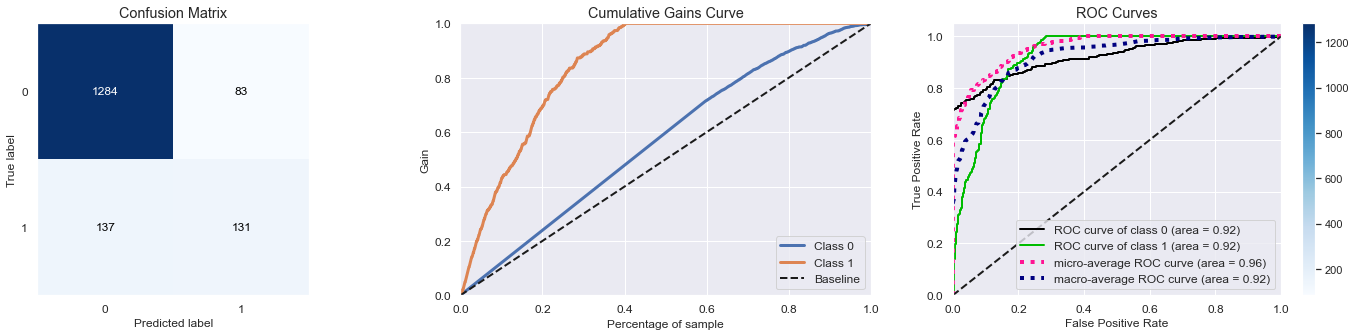

In [27]:
lgbm = LGBMClassifier(n_jobs=-1)
lgbm_model = lgbm.fit(X_train, y_train)
yh_lgbm = lgbm_model.predict(X_test)
yhp_lgbm = lgbm_model.predict_proba(X_test)

lgbm_result = df_scores(model_name='LGBMClassifier', y_test=y_test, y_pred=yh_lgbm, y_proba=yhp_lgbm, normalize=True)
lgbm_result

## LGBM Classifier CV

In [28]:
lgbm_cv = cross_validation(lgbm, X_train, y_train, verb=True, k=10)
lgbm_cv

1 -> 10 Cross Validation Folds
2 -> 10 Cross Validation Folds
3 -> 10 Cross Validation Folds
4 -> 10 Cross Validation Folds
5 -> 10 Cross Validation Folds
6 -> 10 Cross Validation Folds
7 -> 10 Cross Validation Folds
8 -> 10 Cross Validation Folds
9 -> 10 Cross Validation Folds
10 -> 10 Cross Validation Folds


,Model Name,Accuracy,f1_score
0,LGBMClassifier,0.8758 + / - 0.011,0.5562 + / - 0.0503


# 7.0 HYPERPARAMETER FINE TUNING 

## 7.1 Definindo os hyper parametros para o FineTuning

In [29]:
parameters = {'max_depth': np.arange(2, 12, 2), 
              'num_leaves': 2 ** np.arange(2, 10, 2),
              'min_data_in_leaf': np.arange(650, 1050, 50), 
              'learning_rate': np.linspace(0.001, 0.6, 15),
              'colsample_bytree': np.linspace(0.1, 1, 5),
              'subsample': np.linspace(0.01, 1, 15),
              'n_estimators': np.arange(10, 105, 15)}

lgbm_random_cv = RandomizedSearchCV(estimator=lgbm, param_distributions=parameters,
                                    scoring='f1', n_iter=100, cv=10, verbose=2, n_jobs=-1)

a = lgbm_random_cv.fit(X_train, y_train)
a.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[LightGBM] [Warning] min_data_in_leaf is set=650, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=650


LGBMClassifier(learning_rate=0.3860714285714285, max_depth=10,
               min_data_in_leaf=650, n_estimators=40, num_leaves=256,
               subsample=0.3635714285714286)

### 7.1.1 Randomized Search (LGBM Classifier)

[LightGBM] [Warning] min_data_in_leaf is set=650, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=650
1 -> 10 Cross Validation Folds
2 -> 10 Cross Validation Folds
3 -> 10 Cross Validation Folds
4 -> 10 Cross Validation Folds
5 -> 10 Cross Validation Folds
6 -> 10 Cross Validation Folds
7 -> 10 Cross Validation Folds
8 -> 10 Cross Validation Folds
9 -> 10 Cross Validation Folds
10 -> 10 Cross Validation Folds


,Model Name,Accuracy,f1_score
0,LGBMClassifier,0.8741 + / - 0.0085,0.5539 + / - 0.0195


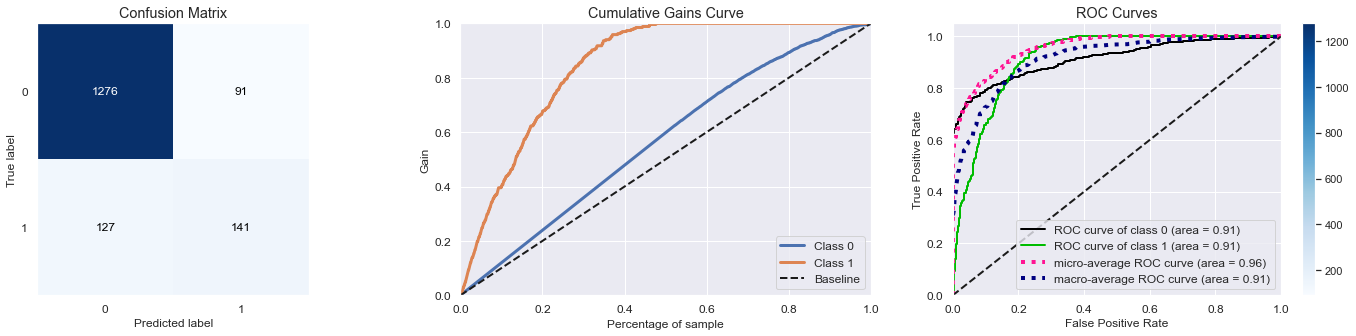

In [33]:
lgbm_tunned = LGBMClassifier(learning_rate=0.3860714285714285, max_depth=10,
                             min_data_in_leaf=650, n_estimators=40, num_leaves=256,
                             subsample=0.3635714285714286)

lgbm_model = lgbm_tunned.fit(X_train, y_train)
yh = lgbm_model.predict(X_test)
yhp = lgbm_model.predict_proba(X_test)

lgbm_model = df_scores(model_name='LGBMClassifier Tunned', y_test=y_test, y_pred=yh, y_proba=yhp, normalize=True)

cross_validation(lgbm, X_train, y_train, verb=True, k=10)


# 8.0 SUBMISSÃO

In [31]:
response = lgbm_tunned.predict(X_valid)
submission(response)

In [32]:
lgbm_cv = cross_validation(lgbm, X_train, y_train, verb=True, k=10)
lgbm_cv

1 -> 10 Cross Validation Folds
2 -> 10 Cross Validation Folds
3 -> 10 Cross Validation Folds
4 -> 10 Cross Validation Folds
5 -> 10 Cross Validation Folds
6 -> 10 Cross Validation Folds
7 -> 10 Cross Validation Folds
8 -> 10 Cross Validation Folds
9 -> 10 Cross Validation Folds
10 -> 10 Cross Validation Folds


,Model Name,Accuracy,f1_score
0,LGBMClassifier,0.8767 + / - 0.0093,0.5609 + / - 0.0353
